# Avaliação das tendências do Crescimento Vegetativo na Região Metropolitana de Curitiba


## Preparação do _Notebook_

Esse documento, por ser construído em Linguagem Python, apresenta textos e código, por essa razão, sua preparação depende de importação das bibliotecas que serão utilizadas nos procedimentos analíticos.

In [21]:
import pandas as pd # importação de biblioteca de manipulação de dados tabulares
import matplotlib.pyplot as plt # importação de biblioteca de plotagem de gráficos 
import numpy as np # importação de biblioteca para cálculos matemáticos
from scipy.optimize import curve_fit # importação de função a ser utilizada para ajuste de modelo preditivo 
from itertools import product # importação de função voltada para otimização de laços de iteração

## Cálculo de Crescimento Vegetativo
Os dados de óbitos foram obtidos a partir do [Sistema de Informações sobre Mortalidade](http://sim.saude.gov.br/), do Ministério da Saúde. O arquivo csv original passou por poucos tratamentos, contando apenas com retirada de metadados, informações de cabeçalho e registros com traços "-" alterados para 0. 
Adiante os dados são importados, com a retirada das linhas que sumarizam totais e alteração de termos mulheres e homens, para masculino e feminino.
Para conferência dos dados, as primeiras cinco linhas da tabela são exibidas

In [22]:
df_obitos = pd.read_csv('../source/tab/originais/mortalidade segundo sexo e faixa etária.csv', sep=';') #carregamento dos dados
df_obitos = df_obitos[~(df_obitos['Faixa Etária'] == 'Total')] # remoção das linhas com total
df_obitos.replace(to_replace={'Mulheres':'Feminino', 'Homens':'Masculino'}, inplace=True) # alteração de registros de mulheres e homens, para Feminino e Masculino
df_obitos.iloc[np.r_[0:2, -2:0]] #visualização das duas primeiras e das duas últimas linhas do DataFrame

,Sexo,Faixa Etária,1996,1997,1998,1999,2000,2001,2002,2003,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,Feminino,Menor 1 ano,512,425,493,449,460,400,365,326,...,239,236,219,221,220,206,181,187,147,139
1,Feminino,1 a 4 anos,88,99,104,62,66,75,58,75,...,38,34,35,33,37,31,26,35,17,19
25,Masculino,80 anos e mais,901,944,1023,993,1070,1099,1149,1285,...,1805,1838,1963,1981,2240,2268,2327,2434,2827,3386
26,Masculino,Idade ignorada,91,60,129,85,40,3,14,51,...,6,5,7,8,2,7,7,3,5,15


In [23]:
df_nascimentos = pd.read_csv('../source/tab/originais/nascidos_vivos_idade_mae_tratado.csv', sep=';') #carregamento dos dados
df_nascimentos.rename(columns={'Idade da mãe':'Faixa Etária'}, inplace=True)
df_nascimentos.iloc[np.r_[0:2, -2:0]] #visualização das duas primeiras e das duas últimas linhas do DataFrame

,Faixa Etária,1994,1995,1996,1997,1998,1999,2000,2001,2002,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,10 a 14 anos,330,358,417,436,447,366,359,397,356,...,345,349,323,298,226,203,158,152,131,111
1,15 a 19 anos,9997,10625,11518,11576,11833,11735,10950,10697,9891,...,8254,8514,7907,7549,6556,5761,5265,4698,4147,3710
10,60 a 64 anos,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
11,Idade ignorada,4407,1717,1149,665,399,360,90,64,14,...,0,0,0,0,2,0,0,0,0,0


In [24]:
pop_1996_2022 = pd.read_csv('../source/tab/results/pop_1996_2022_estimativa_intercensitaria.csv', sep=';')

pop_1996_2022.head(3)

,Sexo,Faixa Etária,1996,1997,1998,1999,2000,2001,2002,2003,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Feminino,Menor 1 ano,24127,24532,24944,25363,25789,25343,24905,24475,...,21923,22011,22098,22186,22275,22363,22452,22542,22631,22722
1,Feminino,1 a 4 anos,94310,96292,98317,100384,102495,100944,99416,97912,...,90137,90861,91591,92327,93069,93816,94570,95330,96096,96868
2,Feminino,5 a 9 anos,119490,121377,123293,125241,127219,125930,124655,123392,...,115640,115885,116131,116378,116625,116872,117120,117369,117618,117868


In [25]:
df_crescimento_vegetativo = pd.concat(
    objs = [
        df_nascimentos.sum()[3:].to_frame().rename(columns={0:'Nascimentos'})
        ,df_obitos.sum()[2:].to_frame().rename(columns={0:'Óbitos'})
        , pop_1996_2022.sum().iloc[2:].to_frame().rename(columns={0:'População'})
    ]
    ,axis=1
)

df_crescimento_vegetativo['Crescimento Vegetativo'] = df_crescimento_vegetativo['Nascimentos'] - df_crescimento_vegetativo['Óbitos']

In [26]:
df_crescimento_vegetativo = pd.concat(
    objs = [
        df_crescimento_vegetativo
        ,df_crescimento_vegetativo['População'].diff().to_frame().rename(columns={'População':'Crescimento Último Ano'})
    ]
    ,axis=1
)



In [27]:
df_crescimento_vegetativo = pd.concat(
    objs = [
        df_crescimento_vegetativo
        ,(df_crescimento_vegetativo['Crescimento Último Ano'] - df_crescimento_vegetativo['Crescimento Vegetativo']).to_frame().rename(columns={0:'Saldo Migratório'})
    ]
    ,axis=1
)

df_crescimento_vegetativo

,Nascimentos,Óbitos,População,Crescimento Vegetativo,Crescimento Último Ano,Saldo Migratório
1996,55396,15378,2514088,40018,NaN,NaN
1997,55626,15227,2584993,40399,70905,30506
1998,55455,15818,2658444,39637,73451,33814
1999,56804,15683,2734538,41121,76094,34973
2000,53955,15962,2813397,37993,78859,40866
2001,52202,15601,2847707,36601,34310,-2291
2002,51555,16107,2883390,35448,35683,235
2003,48669,16750,2920476,31919,37086,5167
2004,49029,17223,2959016,31806,38540,6734
2005,48576,16773,2999058,31803,40042,8239


147179

In [74]:
crescimento_pop_quinquenal = dict()
crescimento_vegetativo_quinquenal = dict()

for ano_final in [2010, 2020]:
    crescimento_pop_quinquenal[str(ano_final)] = df_crescimento_vegetativo.loc[str(ano_final)]['População'] - df_crescimento_vegetativo.loc[str(ano_final - 9)]['População']
    crescimento_vegetativo_quinquenal[str(ano_final)] = df_crescimento_vegetativo.loc[str(ano_final - 8):str(ano_final)]['Crescimento Vegetativo'].sum()

In [77]:
df_crescimento_vegetativo.loc[str(ano_final)]['População'] - df_crescimento_vegetativo.loc[str(ano_final - 9)]['População']

245936

In [78]:
df_crescimento_vegetativo.loc[str(ano_final - 8):str(ano_final)]['Crescimento Vegetativo'].sum()

257748

In [68]:
df_crescimentos = pd.DataFrame(data=[crescimento_vegetativo_quinquenal, crescimento_pop_quinquenal], index=['Vegetativo', 'Populacional']).transpose()

In [69]:
df_crescimentos['Populacional'] - df_crescimentos['Vegetativo']

2010    90779
2020   -20364
dtype: int64

In [46]:
crescimento_pop_quinquenal

{'2005': 185661, '2010': 224774, '2015': 121085, '2020': 147179}

### Crescimento Populacional na RMC entre 1996 e 2022

In [28]:
pop_1996_2022.sum().iloc[-1] - pop_1996_2022.sum().iloc[2]

1045278

### Participação da Imigração no Crescimento Populacional entre 1996 e 2022

In [29]:
pop_1996_2022.sum().iloc[-1] - pop_1996_2022.sum().iloc[2] - df_crescimento_vegetativo.sum().iloc[-1]

809959

### Participação do Crescimento Vegetativo no Crescimento Populacional entre 1996 e 2022

In [30]:
df_crescimento_vegetativo['Crescimento Vegetativo'].sum()

815692

In [31]:
df_crescimento_vegetativo[['Nascimentos', 'Óbitos', 'Crescimento Vegetativo', 'Saldo Migratório']]

,Nascimentos,Óbitos,Crescimento Vegetativo,Saldo Migratório
1996,55396,15378,40018,NaN
1997,55626,15227,40399,30506
1998,55455,15818,39637,33814
1999,56804,15683,41121,34973
2000,53955,15962,37993,40866
2001,52202,15601,36601,-2291
2002,51555,16107,35448,235
2003,48669,16750,31919,5167
2004,49029,17223,31806,6734
2005,48576,16773,31803,8239


<Axes: >

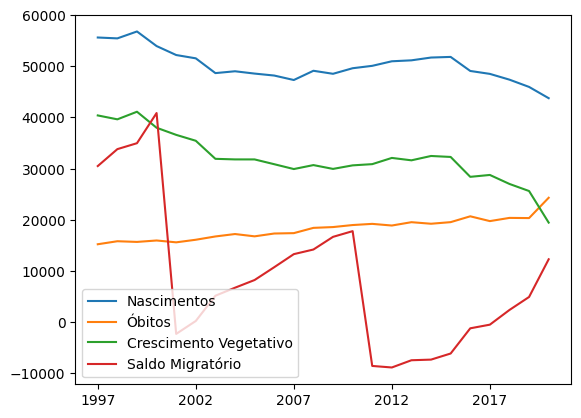

In [32]:
df_crescimento_vegetativo[['Nascimentos', 'Óbitos', 'Crescimento Vegetativo', 'Saldo Migratório']].iloc[1:-2].plot(kind='line')

In [33]:
df_crescimento_vegetativo[]

,Nascimentos,Óbitos,População,Crescimento Vegetativo,Crescimento Último Ano,Saldo Migratório
1996,55396,15378,2514088,40018,NaN,NaN
1997,55626,15227,2584993,40399,70905,30506
1998,55455,15818,2658444,39637,73451,33814
1999,56804,15683,2734538,41121,76094,34973
2000,53955,15962,2813397,37993,78859,40866
2001,52202,15601,2847707,36601,34310,-2291
2002,51555,16107,2883390,35448,35683,235
2003,48669,16750,2920476,31919,37086,5167
2004,49029,17223,2959016,31806,38540,6734
2005,48576,16773,2999058,31803,40042,8239


In [13]:
df_crescimento_vegetativo[['Nascimentos', 'Óbitos', 'Crescimento Vegetativo', 'Saldo Migratório']].loc['1996':'2000']['Crescimento Vegetativo'].sum()

199168

In [14]:
df_obitos.sum()[2:].to_frame().rename(columns={0:'Óbitos'})

,Óbitos
1996,15378
1997,15227
1998,15818
1999,15683
2000,15962
2001,15601
2002,16107
2003,16750
2004,17223
2005,16773


<Axes: >

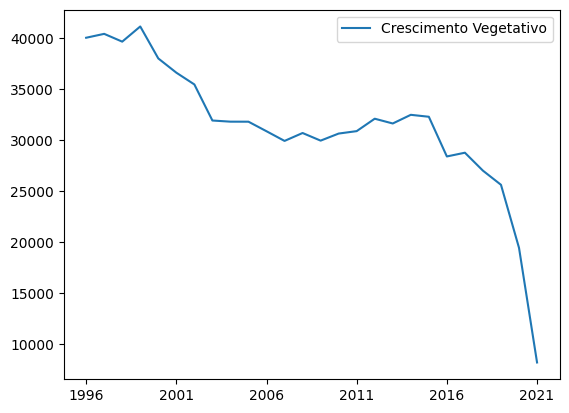

In [15]:
df_crescimento_vegetativo = (df_nascimentos.sum()[3:] - df_obitos.sum()[2:]).to_frame().rename(columns={0:'Crescimento Vegetativo'})
df_crescimento_vegetativo.plot(kind='line')

In [16]:
crescimento_pop_1996_2000 = pop_1996_2022['2000'].sum() - pop_1996_2022['1996'].sum()
crescimento_vegetativo_1996_2000 = df_crescimento_vegetativo['Crescimento Vegetativo'].loc['1996':'2000'].sum()

In [17]:
print(f'Crescimento Populacional Total entre 1996 e 2000: {int(crescimento_pop_1996_2000)}')
print(f'Crescimento Linear Populacional Anual entre 1996 e 2000: {int(crescimento_pop_1996_2000 / 4)}')
print(f'Crescimento Vegetativo Entre 1996 e 2000: {int( crescimento_vegetativo_1996_2000)}')
print(f'Crescimento Vegetativo Anual Entre 1996 e 2000: {int( crescimento_vegetativo_1996_2000 / 4)}')
print(f'Crescimento Populacional entre 1996 a 2000, subtraído crescimento vegetativo do período: {int(crescimento_pop_1996_2000 - crescimento_vegetativo_1996_2000)}')
print(f'Crescimento Populacional Anual entre 1996 a 2000, subtraído crescimento vegetativo do período: {int((crescimento_pop_1996_2000 - crescimento_vegetativo_1996_2000)/4)}')

Crescimento Populacional Total entre 1996 e 2000: 299309
Crescimento Linear Populacional Anual entre 1996 e 2000: 74827
Crescimento Vegetativo Entre 1996 e 2000: 199168
Crescimento Vegetativo Anual Entre 1996 e 2000: 49792
Crescimento Populacional entre 1996 a 2000, subtraído crescimento vegetativo do período: 100141
Crescimento Populacional Anual entre 1996 a 2000, subtraído crescimento vegetativo do período: 25035


In [18]:
crescimento_pop_2005_2010 = pop_1996_2022['2010'].sum() - pop_1996_2022['2005'].sum()
crescimento_vegetativo_2005_2010 = df_crescimento_vegetativo['Crescimento Vegetativo'].loc['2005':'2010'].sum()

In [19]:
print(f'Crescimento Populacional Total entre 1996 e 2000: {int(crescimento_pop_2005_2010)}')
print(f'Crescimento Linear Populacional Anual entre 1996 e 2000: {int(crescimento_pop_2005_2010 / 5)}')
print(f'Crescimento Vegetativo Entre 1996 e 2000: {int(crescimento_vegetativo_2005_2010)}')
print(f'Crescimento Vegetativo Anual Entre 1996 e 2000: {int( crescimento_vegetativo_2005_2010 / 5)}')
print(f'Crescimento Populacional entre 1996 a 2000, subtraído crescimento vegetativo do período: {int(crescimento_pop_2005_2010 - crescimento_vegetativo_2005_2010)}')
print(f'Crescimento Populacional Anual entre 1996 a 2000, subtraído crescimento vegetativo do período: {int((crescimento_pop_2005_2010 - crescimento_vegetativo_2005_2010)/5)}')

Crescimento Populacional Total entre 1996 e 2000: 224774
Crescimento Linear Populacional Anual entre 1996 e 2000: 44954
Crescimento Vegetativo Entre 1996 e 2000: 183882
Crescimento Vegetativo Anual Entre 1996 e 2000: 36776
Crescimento Populacional entre 1996 a 2000, subtraído crescimento vegetativo do período: 40892
Crescimento Populacional Anual entre 1996 a 2000, subtraído crescimento vegetativo do período: 8178


In [20]:
df_crescimento_vegetativo

,Crescimento Vegetativo
1996,40018
1997,40399
1998,39637
1999,41121
2000,37993
2001,36601
2002,35448
2003,31919
2004,31806
2005,31803
